# Pricing elasticity

Analysing relationship between price and quantity sold

# Libraries

In [1]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt  # Graphics (normal)
plt.style.use('seaborn-v0_8') # Style for matplotlib charts (optional, but makes easier to read charts)
plt.rcParams['figure.figsize'] = [9.3, 3.5] # Size for matplotlib charts (optional, but useful) 

import plotly.express as px  # Graphics (more options and interactivity)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime, timedelta  # Dealing with data

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.api as sm # Allows linear (or logarithmical regression with Confidence Intervals)

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, r2_score # Assess fitting quality of models

# Data import

Consumption of a product

In [2]:
sales = pd.read_csv(r'C:\Arquivos\Fermin\2023-12_Aprender\Machine Learning\Proyecto - Price elasticity\dummy_sales.csv')

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1560 non-null   int64  
 1   SalesDate      1560 non-null   object 
 2   SKU            1560 non-null   object 
 3   sum_value      1560 non-null   float64
 4   sum_units      1560 non-null   float64
 5   average_price  1560 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 73.3+ KB


In [4]:
sales.sample(10)

Unnamed: 0   SalesDate    SKU  sum_value  sum_units  average_price
1446        1447  29/01/2017  SKU_F  177682.40   10009.33           5.65
763          764  15/10/2017  SKU_K  117250.44   18951.58           1.97
915          916  18/08/2019  SKU_D  147861.25   11194.89           4.20
205          206  04/11/2018  SKU_D   89157.10    6973.91           4.07
1411        1412  28/05/2017  SKU_A   59006.99    8845.04           2.12
604          605  12/05/2019  SKU_C  138023.66   18194.30           2.41
220          221  05/02/2017  SKU_J   74606.72    6307.90           3.76
452          453  09/10/2016  SKU_B  110915.38    6554.08           5.39
1550        1551  31/12/2017  SKU_J   82550.97    6269.65           4.19
1491        1492  30/06/2019  SKU_A   23889.90    3451.95           2.20

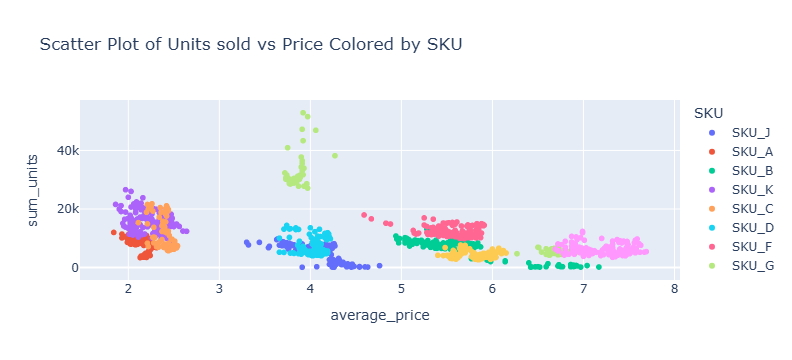

In [5]:
# Scatter plot
figplotly = px.scatter(
    sales,
    x=sales.average_price,
    y=sales.sum_units,
    color=sales.SKU,  # Color points by unique values in 'Category'
    title='Scatter Plot of Units sold vs Price Colored by SKU'
)

figplotly.show()


## Data cleaning

- Removing columns 0 and 3
- Renaming columns
- Using dates as dataframe index
- Ensure 'sku' is treated as a categorical variable with sorted categories

In [6]:
df = sales[[#'Unnamed: 0', 
               'SalesDate', 
               'SKU', 
               #'sum_value', 
               'sum_units',
               'average_price']]

df.columns

Index(['SalesDate', 'SKU', 'sum_units', 'average_price'], dtype='object')

In [7]:
df.columns = ['date', 'sku', 'quantity', 'price_avg']

df.head()

date    sku  quantity  price_avg
0  01/01/2017  SKU_J   5478.73       4.12
1  01/01/2017  SKU_A   7978.37       2.16
2  01/01/2017  SKU_B   6218.20       5.54
3  01/01/2017  SKU_K  11146.23       2.05
4  01/01/2017  SKU_C   6686.17       2.44

In [8]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Set 'Date' as the index
df.set_index('date', inplace=True)


C:\Users\fc2\AppData\Local\Temp\ipykernel_14572\2190349586.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Just to keep dataframe ordered by time

In [9]:
df = df.sort_index()

# Visualization

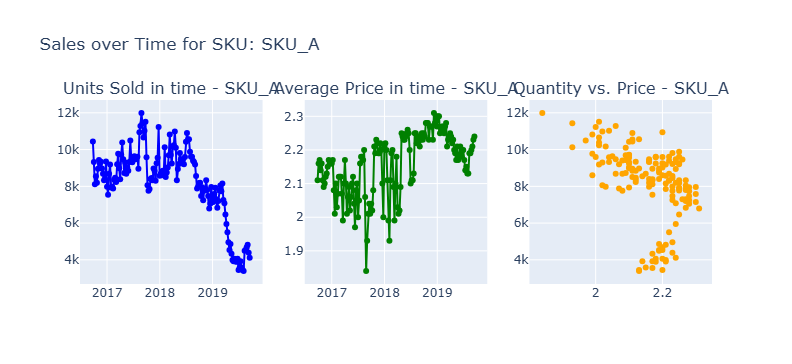

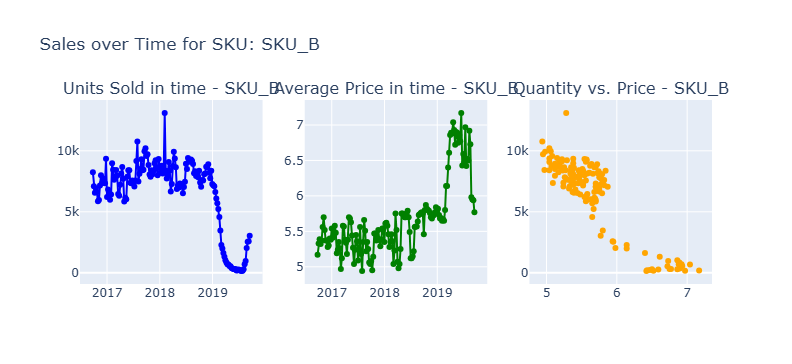

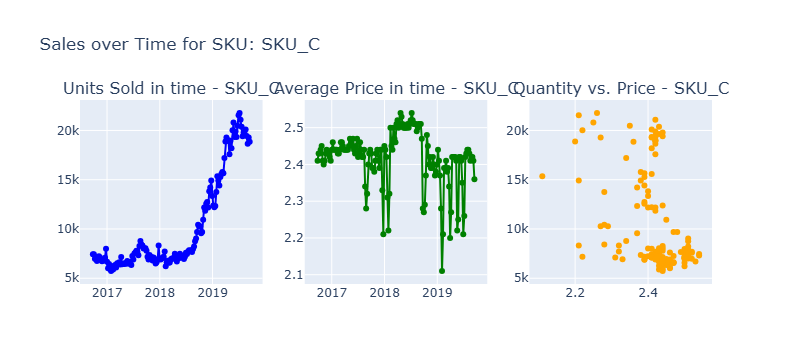

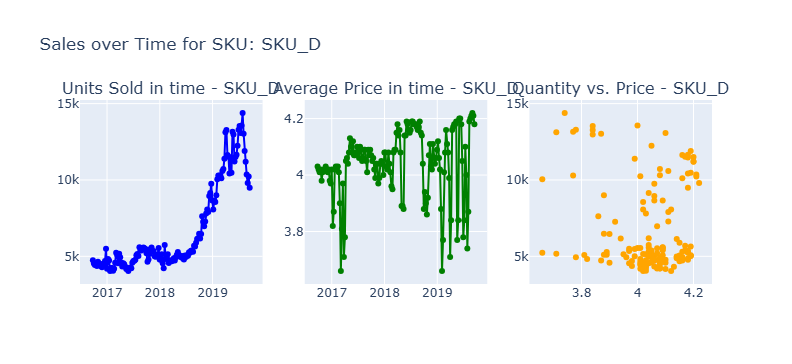

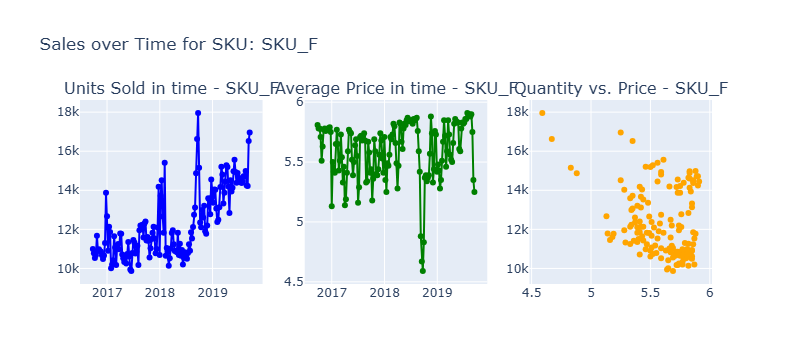

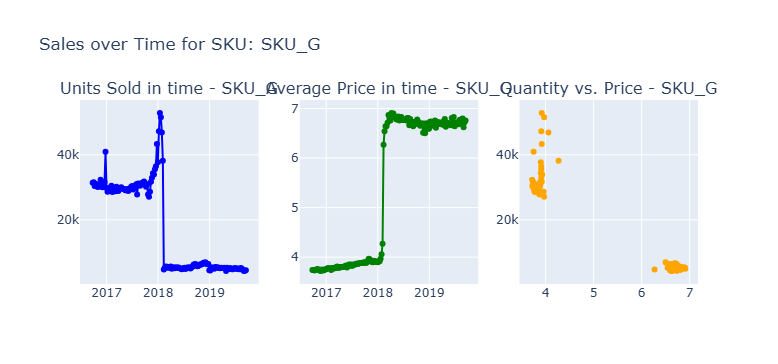

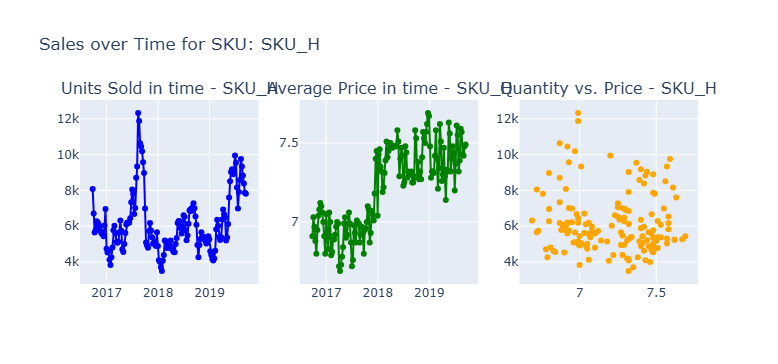

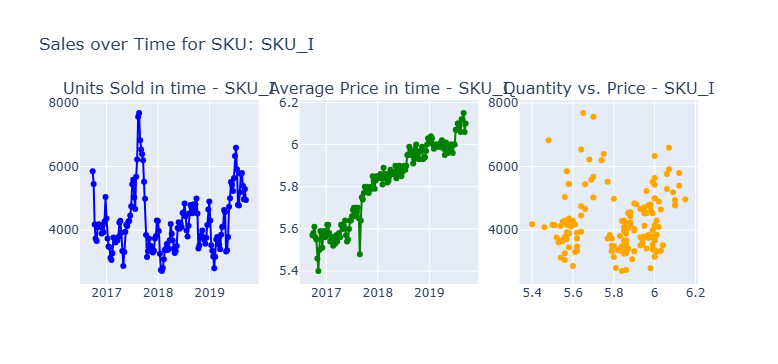

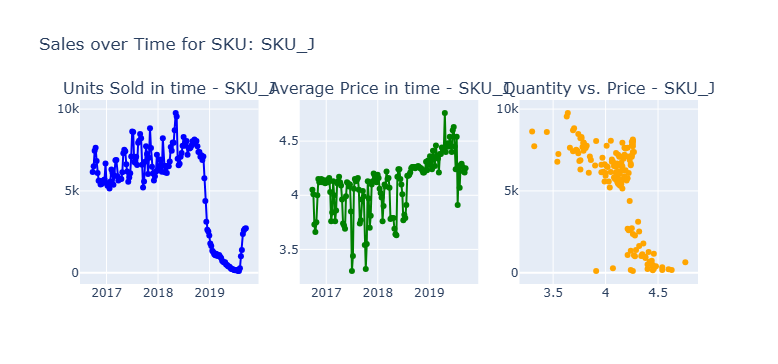

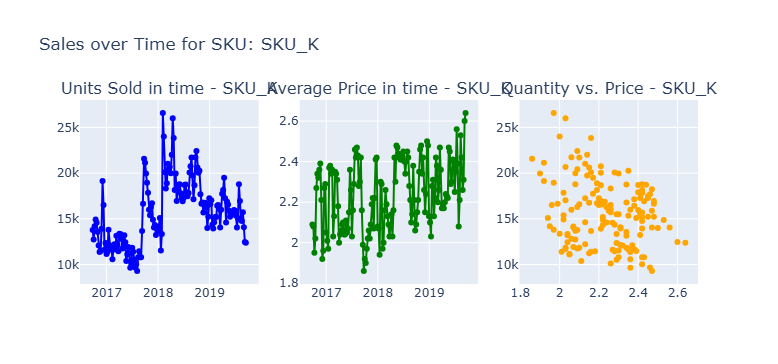

In [10]:
# Loop through SKUs in alphabetical order
for unique_sku in sorted(df.sku.unique()):
    df_filtered = df.loc[df.sku == unique_sku]

    # Create subplot layout: 1 row, 3 columns
    figplotly = make_subplots(
        rows=1, cols=3,
        subplot_titles=[f'Units Sold in time - {unique_sku}', f'Average Price in time - {unique_sku}', f'Quantity vs. Price - {unique_sku}']
    )

    # Left chart: Quantity
    figplotly.add_trace(
        go.Scatter(
            x=df_filtered.index,
            y=df_filtered.quantity,
            mode='lines + markers',
            marker=dict(color='blue'),
            name='Quantity'
        ),
        row=1, col=1
    )

    # Central chart: Price Avg
    figplotly.add_trace(
        go.Scatter(
            x=df_filtered.index,
            y=df_filtered.price_avg,
            mode='lines + markers',
            marker=dict(color='green'),
            name='Price Avg'
        ),
        row=1, col=2
    )

    # Right chart: Quantity vs. Price avg (elasticity)
    figplotly.add_trace(
        go.Scatter(
            x=df_filtered.price_avg,
            y=df_filtered.quantity,
            mode='markers',
            marker=dict(color='orange'),
            name='Price Avg'
        ),
        row=1, col=3
    )

    # Update layout
    figplotly.update_layout(
        title_text=f'Sales over Time for SKU: {unique_sku}',
        showlegend=False,
        height=350,
        width=990
    )

    figplotly.show()

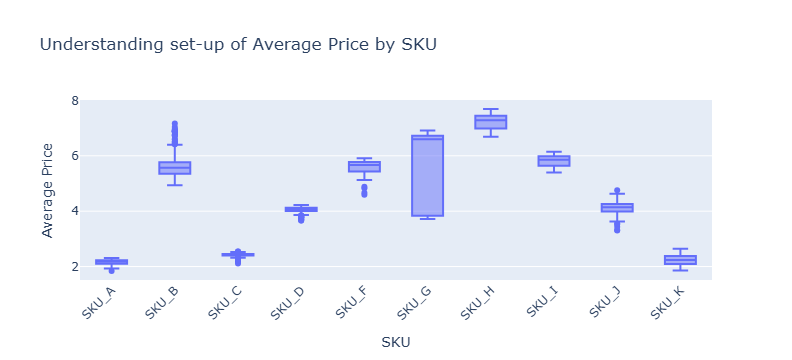

In [11]:
# Easier to code using plotly

fig = px.box(
    df,
    x='sku',
    y='price_avg',
    title='Understanding set-up of Average Price by SKU',
    #color='sku', # Optional, not required in this case
    category_orders={'sku': sorted(df['sku'].unique())}  # Alphabetical order
)

fig.update_layout(
    xaxis_title='SKU',
    yaxis_title='Average Price',
    xaxis_tickangle=-45
)

fig.show()


# Calculating price elasticity

### Starting with a single SKU

In [12]:
df_train_elasticity = df.loc[df.sku=='SKU_B']

In [13]:

X = np.log(df_train_elasticity.price_avg)
y = np.log(df_train_elasticity.quantity)

# Add constant for intercept
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Calculate log(Quantity) = Intercept + elasticity · log(Price)
intercept = model.params['const']
elasticity = model.params['price_avg']

mean_absolute_percentage_error(y,model.predict(X))

print(f"Intercept (log-log space): {intercept:.4f}")
print(f"Price Elasticity: {elasticity:.4f}")
print(f'Mean absolute percentage error (log-log space): {mean_absolute_percentage_error(y,model.predict(X)):.2%}')


# Confidence intervals
print('Confidence intervals for parameters:')
display(model.conf_int(alpha=0.05))  # 95% CI

Intercept (log-log space): 27.3323
Price Elasticity: -10.8884
Mean absolute percentage error (log-log space): 5.42%
Confidence intervals for parameters:


0          1
const      25.606464  29.058118
price_avg -11.883929  -9.892863

In [14]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     466.8
Date:                Fri, 15 Aug 2025   Prob (F-statistic):           1.77e-48
Time:                        13:37:48   Log-Likelihood:                -126.09
No. Observations:                 156   AIC:                             256.2
Df Residuals:                     154   BIC:                             262.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3323      0.874     31.286      0.0

In [15]:
# Step 1: Create prediction space in log(price)
log_price_range = np.linspace(np.log(df_train_elasticity.price_avg.min()),
                              np.log(df_train_elasticity.price_avg.max()), 500)
X_pred = sm.add_constant(log_price_range)

# Step 2: Predict log(quantity) and get confidence intervals
preds = model.get_prediction(X_pred)
pred_summary = preds.summary_frame(alpha=0.05)

# Step 3: Convert predictions back to original scale
price_range = np.exp(log_price_range)
quantity_pred = np.exp(pred_summary['mean'])
ci_lower = np.exp(pred_summary['mean_ci_lower'])
ci_upper = np.exp(pred_summary['mean_ci_upper'])


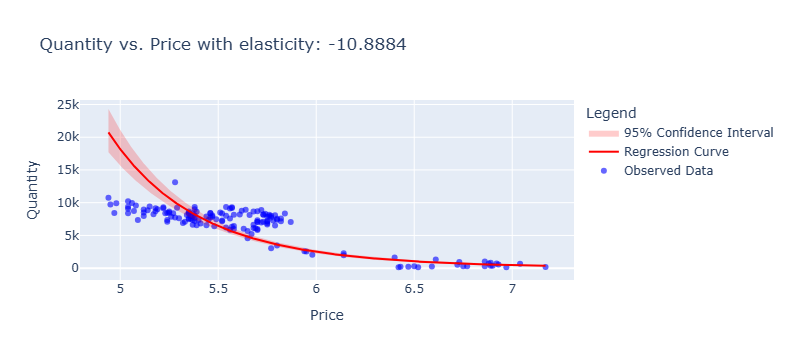

In [16]:

# Create the scatter plot for observed data
scatter = go.Scatter(
    x=df_train_elasticity.price_avg,
    y=df_train_elasticity.quantity,
    mode='markers',
    marker=dict(color='blue', opacity=0.6),
    name='Observed Data'
)

# Regression curve
regression = go.Scatter(
    x=price_range,
    y=quantity_pred,
    mode='lines',
    line=dict(color='red'),
    name='Regression Curve'
)

# Confidence interval (as filled area between ci_lower and ci_upper)
ci_upper_trace = go.Scatter(
    x=price_range,
    y=ci_upper,
    mode='lines',
    line=dict(width=0),
    showlegend=False
)

ci_lower_trace = go.Scatter(
    x=price_range,
    y=ci_lower,
    mode='lines',
    fill='tonexty',  # fill between this trace and the previous one
    fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(width=0),
    name='95% Confidence Interval'
)

# Combine all traces
fig = go.Figure(data=[scatter, regression, ci_upper_trace, ci_lower_trace])

# Customize layout
fig.update_layout(
    title=f'Quantity vs. Price with elasticity: {elasticity:.4f}',
    xaxis_title='Price',
    yaxis_title='Quantity',
    legend=dict(title='Legend'),
    #hovermode='x unified'  # To activate in case you want to see all data figures at once
)

# Show the interactive plot
fig.show()

#### Checking model with last price

In [17]:
last_price = df_train_elasticity.iloc[-1, -1]
last_quantity = df_train_elasticity.iloc[-1, -2]

In [18]:
# Log-transform the input price
log_last_price = np.array([np.log(last_price)]) # it must be an array for next step

# Create a 2D array with constant and log(price)
X_new = sm.add_constant(log_last_price, has_constant='add') # Need to add 'has_constant, as array has only 1 value'

# Predict log(quantity)
log_quantity_pred = model.predict(X_new)

# Convert back to original scale

quantity_pred = np.exp(log_quantity_pred[0])

print(f'For price {last_price}:')
print(f"Predicted Quantity: {quantity_pred:,.2f}")
print(f"Actual Quantity: {last_quantity:,.2f}")



For price 5.77:
Predicted Quantity: 3,821.90
Actual Quantity: 3,033.51


Comment:

Despite the value divergency, this calculation is a valid first step for a eventually deeper pricing analysis.

#### Same calculation, with 1% price increase

In [19]:
price_increased_1_percent = last_price * 1.01

In [20]:
# Log-transform the input price
log_price_increased_1_percent =np.array([np.log(price_increased_1_percent)]) 

# Create a 2D array with constant and log(price)
X_new_1_percent = sm.add_constant(log_price_increased_1_percent, has_constant='add')
#X_new_1_percent = np.array([[1, log_price_increased_1_percent]])  # shape (1, 2)

# Predict log(quantity)
log_quantity_pred_1_percent = model.predict(X_new_1_percent)

# Convert back to original scale
quantity_pred_1_percent = np.exp(log_quantity_pred_1_percent[0])

print(f'For price {price_increased_1_percent:.2f}:')
print(f"Predicted Quantity: {quantity_pred_1_percent:,.2f}")

For price 5.83:
Predicted Quantity: 3,429.47


In [21]:
delta_quantity_percent = (quantity_pred_1_percent - quantity_pred) / quantity_pred

elasticity_calculated = delta_quantity_percent / 0.01 # 0.01 is (price_increased_1_percent - last_price) / last_price

print(f'Quantity increase with price increase of 1% at last price: {delta_quantity_percent:,.1%}')
print(f'Calculated elasticity with price increase of 1% at last price: {elasticity_calculated:,.2f}')

Quantity increase with price increase of 1% at last price: -10.3%
Calculated elasticity with price increase of 1% at last price: -10.27


Comment:

This elasticity value (-10.27) is qualitatively similar to elasticity derived from log-log linear regression model (-10.88).

Moreover, this elasticity value is inside the confidence interval 95% calculated for elasticity (-11.883929, 	-9.892863)


Values should be considered orientative and by no means a substitute of professional analysis.

## For all SKUs, elasticity calculation

In [22]:
# List to collect summary info
elasticity_summary_data = []

for unique_sku in sorted(df.sku.unique()):
    df_filtered = df.loc[df.sku == unique_sku]

    # log-log conversion
    X = np.log(df_filtered.price_avg)
    y = np.log(df_filtered.quantity)

    # Add constant for intercept
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()
    model_name = f'model_{unique_sku}'
    globals()[model_name] = model

    # Extract metrics
    elasticity = model.params['price_avg']
    intercept = model.params['const']
    mape = mean_absolute_percentage_error(y, model.predict(X))

    # Store in globals
    globals()[f'intercept_{unique_sku}'] = model.params['const']
    globals()[f'elasticity_{unique_sku}'] = elasticity
    globals()[f'MAPE_{unique_sku}'] = mape

    # Append to summary list
    elasticity_summary_data.append({
        'SKU': unique_sku,
        'elasticity': elasticity,
        'intercept': intercept,
        'MAPE': mape,
        'model': model_name
    })

# Create summary DataFrame
df_elasticity_summary = pd.DataFrame(elasticity_summary_data)

# Display the result
display(df_elasticity_summary)

SKU  elasticity  intercept      MAPE        model
0  SKU_A   -2.557169  10.940992  0.022157  model_SKU_A
1  SKU_B  -10.888396  27.332291  0.054172  model_SKU_B
2  SKU_C   -5.903158  14.343724  0.032405  model_SKU_C
3  SKU_D   -1.347812  10.608868  0.035793  model_SKU_D
4  SKU_F   -0.955552  11.052268  0.011696  model_SKU_F
5  SKU_G   -3.167040  14.613189  0.010535  model_SKU_G
6  SKU_H   -0.596708   9.874453  0.022429  model_SKU_H
7  SKU_I    0.455494   7.530485  0.019932  model_SKU_I
8  SKU_J  -10.374746  22.859081  0.094043  model_SKU_J
9  SKU_K   -0.669493  10.168893  0.019148  model_SKU_K

In [23]:
# Sort the DataFrame by elasticity in descending order
df_sorted = df_elasticity_summary.sort_values(by='elasticity', ascending=True)

df_sorted['elasticity'] = df_sorted.elasticity.round(2)


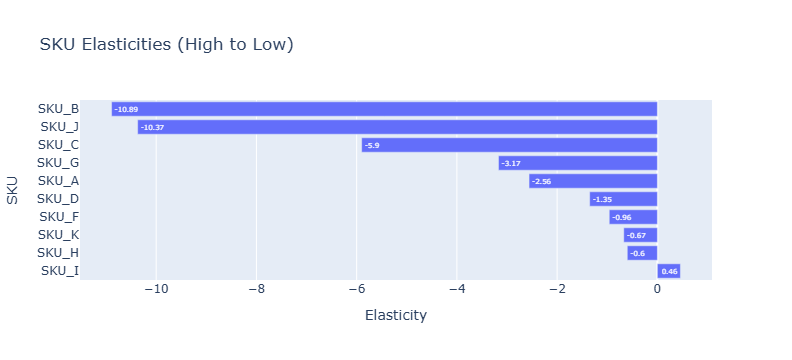

In [24]:
figplotly = px.bar(
    df_sorted,
    x='elasticity',
    y='SKU',
    orientation='h',
    text='elasticity',  # Show values on bars, optional
    title='SKU Elasticities (High to Low)',
    labels={'elasticity': 'Elasticity', 'SKU': 'SKU'}
)

# Reverse the y-axis to show highest elasticity at the top
figplotly.update_layout(yaxis=dict(autorange='reversed'))

# Show the plot
figplotly.show()


## Visualization

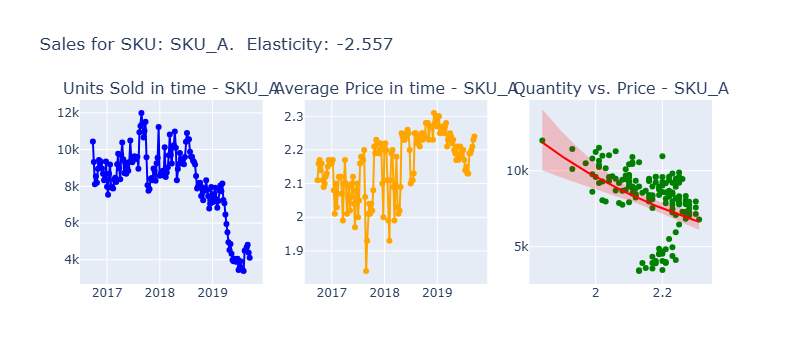

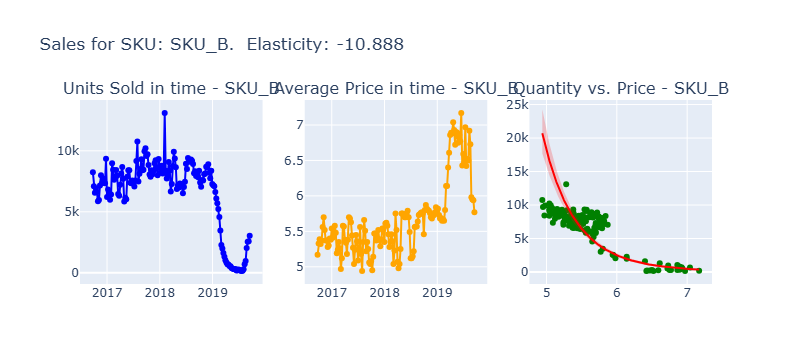

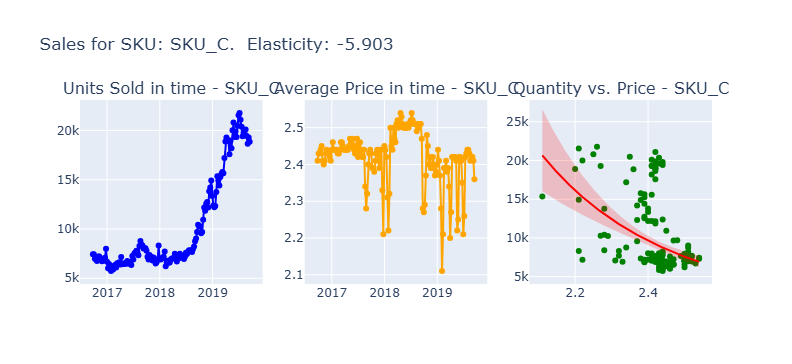

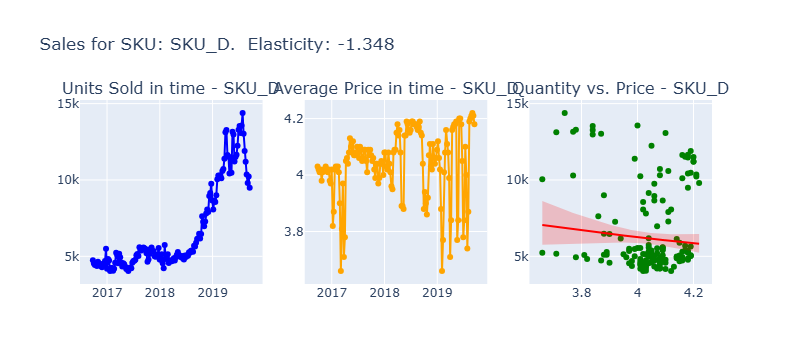

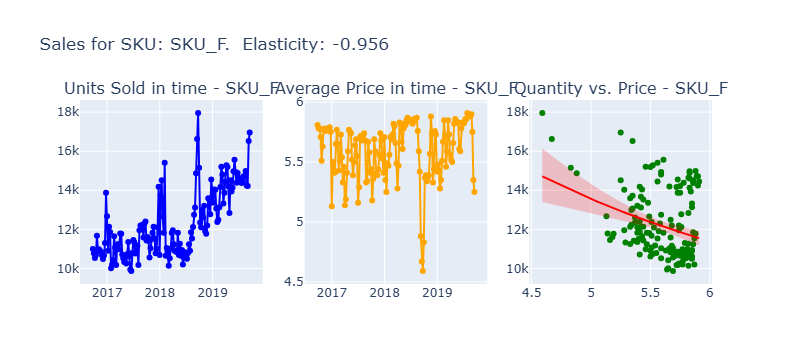

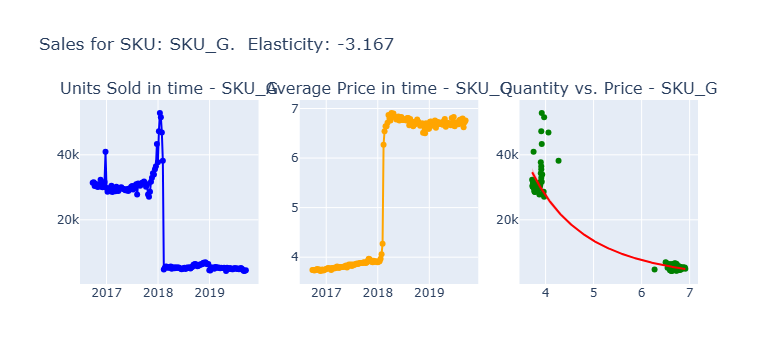

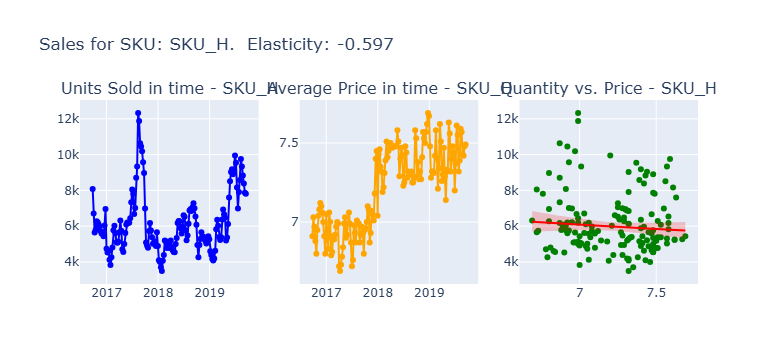

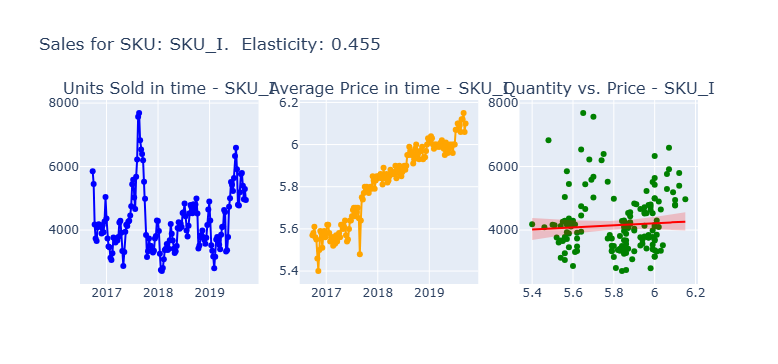

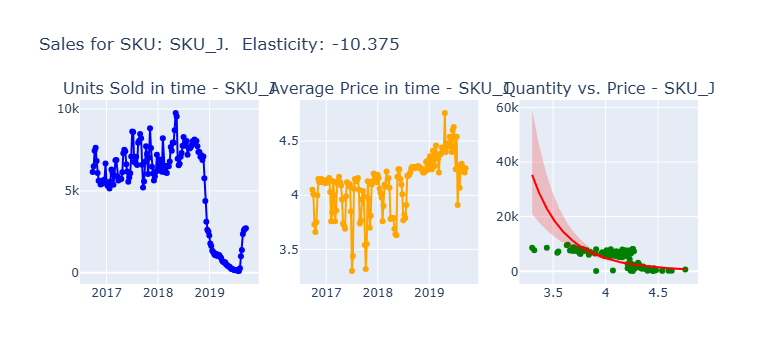

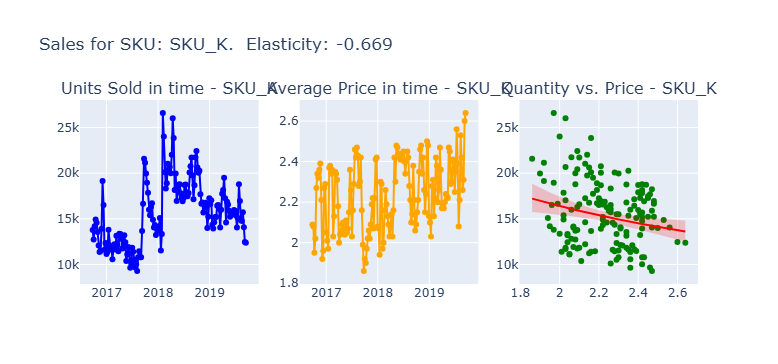

In [25]:
# Loop through SKUs in alphabetical order
for unique_sku in sorted(df.sku.unique()):
    df_filtered = df.loc[df.sku == unique_sku]

    # Create subplot layout: 1 row, 3 columns
    figplotly = make_subplots(
        rows=1, cols=3,
        subplot_titles=[f'Units Sold in time - {unique_sku}', f'Average Price in time - {unique_sku}', f'Quantity vs. Price - {unique_sku}']
    )

    # Left chart: Quantity
    figplotly.add_trace(
        go.Scatter(
            x=df_filtered.index,
            y=df_filtered.quantity,
            mode='lines + markers',
            marker=dict(color='blue'),
            name='Quantity'
        ),
        row=1, col=1
    )

    # Central chart: Price Avg
    figplotly.add_trace(
        go.Scatter(
            x=df_filtered.index,
            y=df_filtered.price_avg,
            mode='lines + markers',
            marker=dict(color='orange'),
            name='Price Avg'
        ),
        row=1, col=2
    )

    # Right chart: Quantity vs. Price avg, including log-log linear regression model (constant elasticity)
    figplotly.add_trace(
        go.Scatter(
            x=df_filtered.price_avg,
            y=df_filtered.quantity,
            mode='markers',
            marker=dict(color='green'),
            name='Price Avg'
        ),
        row=1, col=3
    )

    # Step 1: Create prediction space in log(price)
    log_price_range = np.linspace(np.log(df_filtered.price_avg.min()),
                              np.log(df_filtered.price_avg.max()), 500)
    X_pred = sm.add_constant(log_price_range)


    # Step 2: Predict log(quantity) and get confidence intervals
    
    model_name = df_elasticity_summary.loc[df_elasticity_summary.SKU == unique_sku, 'model'].values[0]
    model = globals()[model_name]
    preds = model.get_prediction(X_pred)
    pred_summary = preds.summary_frame(alpha=0.05)

    # Step 3: Convert predictions back to original scale
    price_range = np.exp(log_price_range)
    quantity_pred = np.exp(pred_summary['mean'])
    ci_lower = np.exp(pred_summary['mean_ci_lower'])
    ci_upper = np.exp(pred_summary['mean_ci_upper'])

    # Regression curve
    figplotly.add_trace(
        go.Scatter(
        x=price_range,
        y=quantity_pred,
        mode='lines',
        line=dict(color='red'),
        name='Log-Log Regression Curve'
        ),
        row=1, col=3
    )

    # Confidence interval (as filled area between ci_lower and ci_upper)
    figplotly.add_trace(
        go.Scatter(
        x=price_range,
        y=ci_upper,
        mode='lines',
        line=dict(width=0),
        name='95% upper CI',
        showlegend=False
        ),
        row=1, col=3
    )

    figplotly.add_trace(
        go.Scatter(
        x=price_range,
        y=ci_lower,
        mode='lines',
        fill='tonexty',  # fill between this trace and the previous one
        fillcolor='rgba(255, 0, 0, 0.2)',
        line=dict(width=0),
        name='95% lower CI'
        ),
        row=1, col=3
    )


    decimals_for_elasticity = 3
    elasticity_rounded = round(df_elasticity_summary.loc[df_elasticity_summary.SKU == unique_sku, 'elasticity'].values[0],decimals_for_elasticity)
    # Update layout
    figplotly.update_layout(
        title_text=f'Sales for SKU: {unique_sku}.  Elasticity: {elasticity_rounded}',
        showlegend=False,
        height=350,
        width=990
    )

    figplotly.show()


# Calculating cross-price elasticity

The cross-price elasticity of A with respect to B measures how the quantity of A responds to a price change in B. Conversely, the elasticity of B with respect to A measures how the quantity of B responds to a price change in A.
These two can differ due to:
- Consumer preferences: People might switch from B to A more readily than from A to B.
- Market share differences: A dominant brand may influence demand more than a niche competitor.
- Usage context: One product might be a stronger complement or substitute than the other.


## Starting with a single SKU

The cross-elasticity of all SKUs in relationship with the change of price of a single SKU

I will use the cross-elasticity of SKU_I in relationship with SKU_B

In [26]:
y_quantity_SKU_I = df.loc[df.sku=='SKU_I'].quantity

X_price_SKU_I = df.loc[df.sku=='SKU_I'].price_avg  # To check influence of own price

X_price_SKU_B = df.loc[df.sku=='SKU_B'].price_avg  # To check influence of price of different SKU

Log-Log linear regression, need to transform to log (natural logarithms)

In [27]:
y_log_quantity = np.log(y_quantity_SKU_I)
X_log_price_own_sku = np.log(X_price_SKU_I)
X_log_price_other_sku = np.log(X_price_SKU_B)

X_log_price_joined = pd.DataFrame({
    'own_sku': X_log_price_own_sku,
    'other_sku': X_log_price_other_sku    
    })

In [28]:
X_log_price = sm.add_constant(X_log_price_joined)

model_cross = sm.OLS(y_log_quantity, X_log_price).fit()
print(model_cross.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.601
Date:                Fri, 15 Aug 2025   Prob (F-statistic):             0.0775
Time:                        13:37:50   Log-Likelihood:                 25.276
No. Observations:                 156   AIC:                            -44.55
Df Residuals:                     153   BIC:                            -35.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1562      0.977      8.349      0.0

Results show that own_sku price has no statistical relevance.

Let's compare with model without considering own SKU price

In [29]:
X_log_price = sm.add_constant(X_log_price_other_sku)

model_cross = sm.OLS(y_log_quantity, X_log_price).fit()
print(model_cross.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     4.859
Date:                Fri, 15 Aug 2025   Prob (F-statistic):             0.0290
Time:                        13:37:50   Log-Likelihood:                 25.091
No. Observations:                 156   AIC:                            -46.18
Df Residuals:                     154   BIC:                            -40.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6028      0.331     22.937      0.0

The model with just the price of the other SKU has all their coefficients relevant and also Prob (F-statistic) is much lower.

Therefore, we will move forward with this model.

Quick check that model works properly

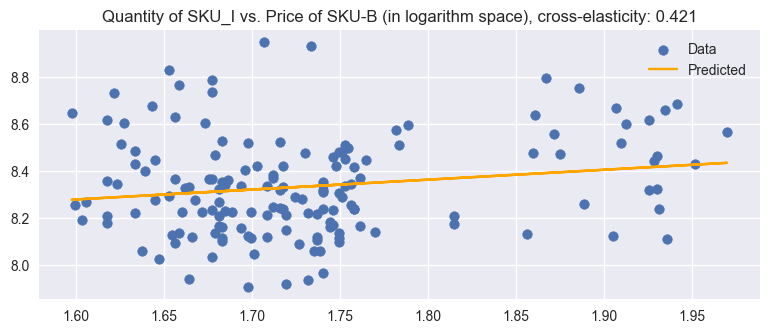

In [30]:
cross_elasticity = round(model_cross.params[1],3)

plt.scatter(X_log_price_other_sku, y_log_quantity, label='Data')
plt.plot(X_log_price_other_sku, model_cross.predict(sm.add_constant(X_log_price_other_sku)), 
            color='orange',
            label='Predicted')
plt.title(f'Quantity of SKU_I vs. Price of SKU-B (in logarithm space), cross-elasticity: {cross_elasticity}')
plt.legend(loc='best')
plt.show()

## For all SKUs, cross-elasticity calculation

In [31]:
# List to collect summary info
cross_elasticity_summary_data = []

for unique_sku_quantity in sorted(df.sku.unique()):
    for unique_sku_price in sorted(df.sku.unique()):
        # variables
        y_quantity = df.loc[df.sku == unique_sku_quantity].quantity
        X_price = df.loc[df.sku == unique_sku_price].price_avg

        # log-log conversion
        X_price_log = np.log(X_price)
        y_quantity_log = np.log(y_quantity)

        # Add constant for intercept
        X_price_log_and_constant = sm.add_constant(X_price_log)

        # Fit model
        model_cross = sm.OLS(y_quantity_log, X_price_log_and_constant).fit()

        # Extract metrics
        cross_elasticity = round(model_cross.params[1],3)

        # Append to summary list
        cross_elasticity_summary_data.append({
            'SKU_q': unique_sku_quantity,
            'SKU_p': unique_sku_price,
            'cross-elasticity': cross_elasticity,
        })

# Create summary DataFrame
df_cross_elasticity_summary = pd.DataFrame(cross_elasticity_summary_data)

# Display the result
print('Results available in dataframe: df_cross_elasticity_summary')
print()
display(df_cross_elasticity_summary.pivot(index='SKU_q', columns='SKU_p', values='cross-elasticity'))

Results available in dataframe: df_cross_elasticity_summary



SKU_p   SKU_A   SKU_B   SKU_C  SKU_D  SKU_F  SKU_G   SKU_H   SKU_I   SKU_J  \
SKU_q                                                                        
SKU_A  -2.557  -2.789   3.034  1.141 -1.155 -0.465  -3.209  -5.328  -2.388   
SKU_B  -4.820 -10.888   9.806  2.735 -7.262 -1.601 -10.405 -16.713  -8.538   
SKU_C   4.321   3.961  -5.903 -0.031  1.281  0.934   6.438   9.784   4.073   
SKU_D   4.169   3.584  -5.287 -1.348  1.286  0.857   5.861   9.046   3.674   
SKU_F   1.173   1.054  -1.926  0.098 -0.956  0.239   1.859   2.876   1.150   
SKU_G -11.593  -5.857  -0.763 -4.590 -3.600 -3.167 -19.633 -23.376  -6.545   
SKU_H  -0.459   0.776  -0.611  1.445  0.712  0.037  -0.597   0.717   0.534   
SKU_I  -0.405   0.421  -0.397  1.368  0.153  0.016  -0.197   0.455   0.439   
SKU_J  -6.985 -10.543  13.922  5.182 -6.790 -1.762 -11.773 -19.140 -10.375   
SKU_K   1.335   0.341   0.920  0.813 -0.106  0.510   3.322   3.962   0.221   

SKU_p  SKU_K  
SKU_q         
SKU_A -0.932  
SKU_B -3.635  
SKU_C  1.865  
SKU_D  1.597  
SKU_F  0.299  
SKU_G -4.424  
SKU_H  0.820  
SKU_I  0.573  
SKU_J -3.171  
SKU_K -0.669

How to extract value of this data:

- Each cell represent the cross-elasticity, with represent the % increase of demand quantity of the SKU listed in the dataframe index (SKU_q), when there is an 1% increase of price of the SKU listed along the columns (SKU_p).
-  The closer to 0 the values, the more independent is the demand behavior of the products
-  Cross-elasticities with '+' sign (>0) mean competitor products (rice 1, rice 2)
-  Cross-elasticities with '-' sign (<0) mean complementary products (peanut butter and jelly)
-  Values are not necessarily symmetrical (customer preferences)

This table can prevent undesired negative side-effects of price change of a product.

### Visualization

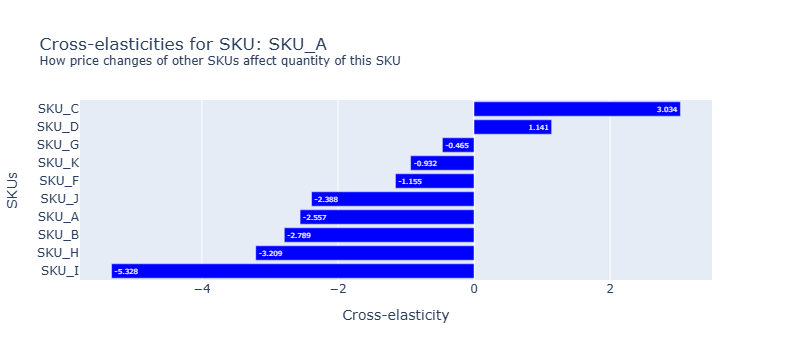

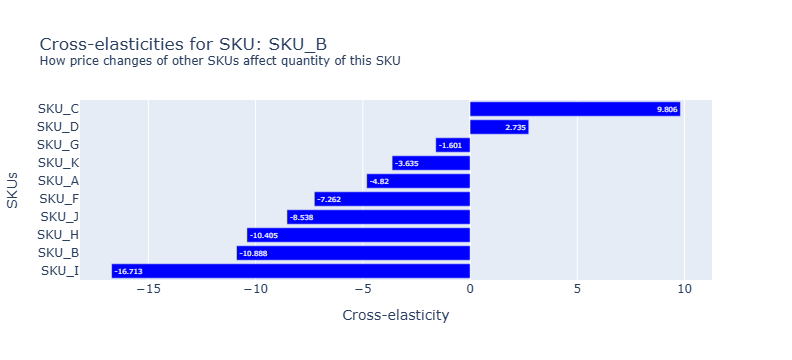

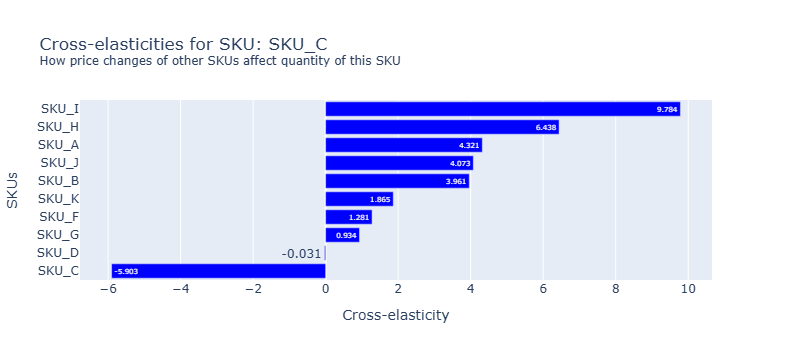

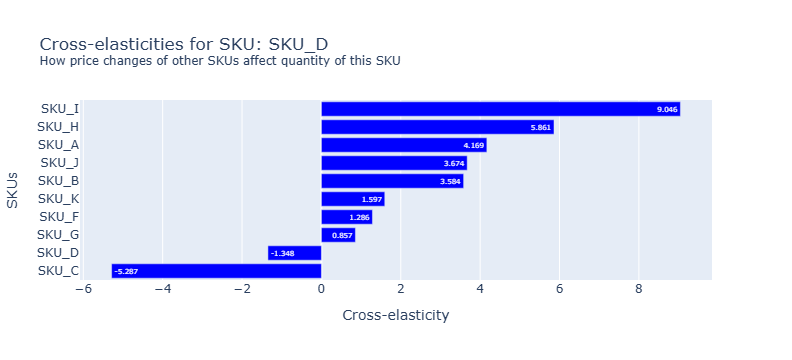

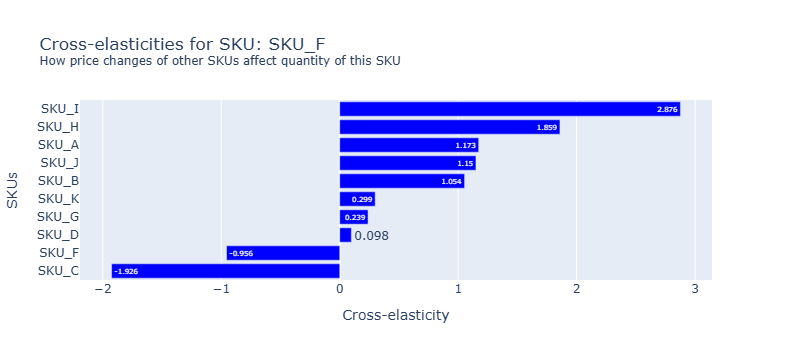

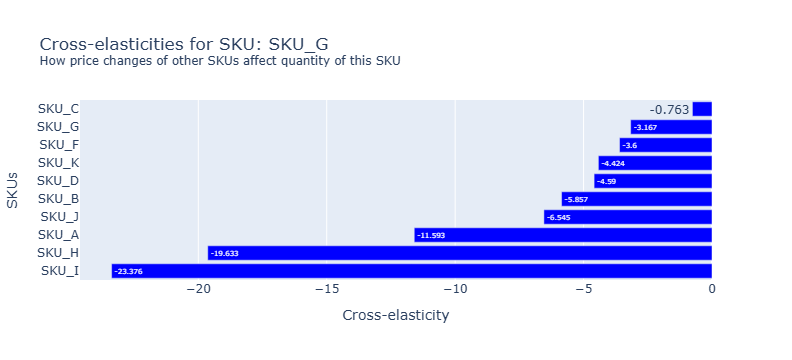

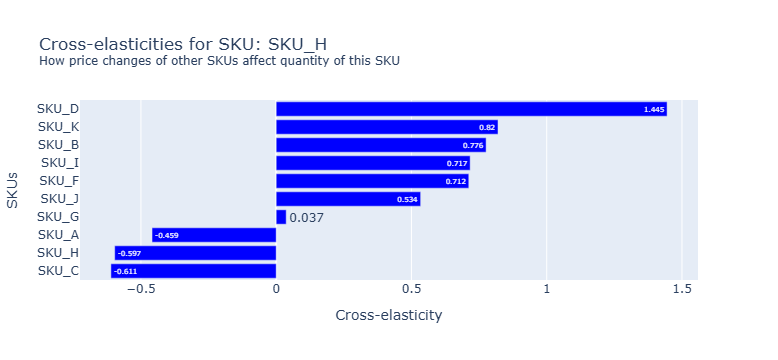

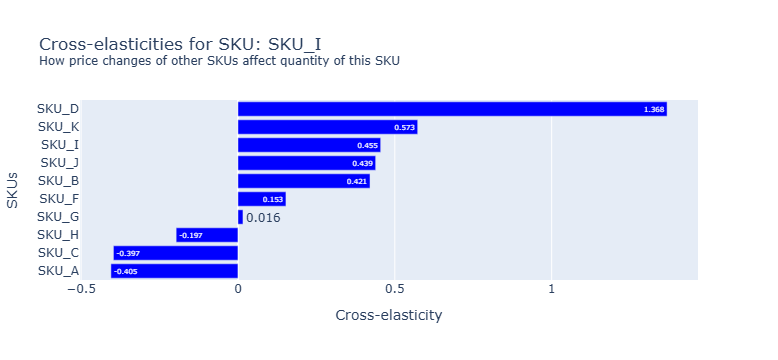

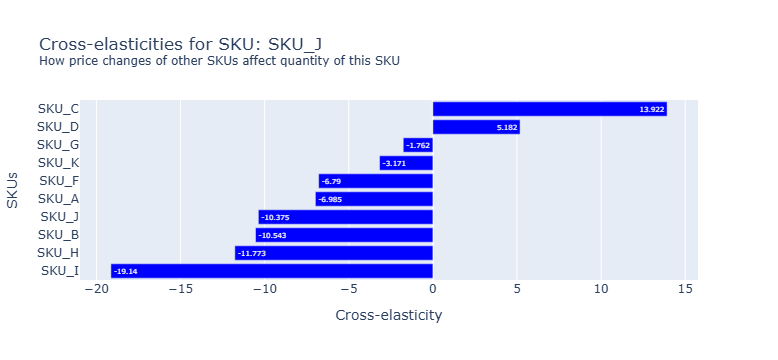

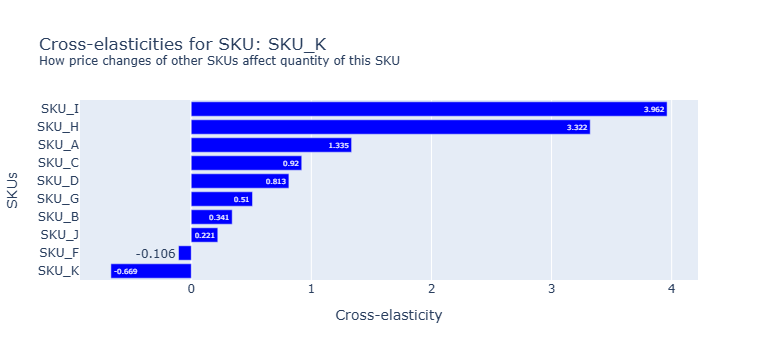

In [32]:
for unique_sku in sorted(df.sku.unique()):
    # Sort the DataFrame by cross-elasticity
    df_sorted = df_cross_elasticity_summary.loc[df_cross_elasticity_summary.SKU_q == unique_sku].sort_values(
            by='cross-elasticity', ascending=False)
    figplotly = px.bar(
        df_sorted,
        x='cross-elasticity',
        y='SKU_p',
        orientation='h',
        color_discrete_sequence=['blue'],
        text='cross-elasticity',  # Show values on bars, optional
        title=f'Cross-elasticities for SKU: {unique_sku}<br><sup>How price changes of other SKUs affect quantity of this SKU</sup>',
        labels={'cross-elasticity': 'Cross-elasticity', 'SKU_p': 'SKUs'}
        )

    # Reverse the y-axis to show highest elasticity at the top
    figplotly.update_layout(yaxis=dict(autorange='reversed'))

    # Show the plot
    figplotly.show()



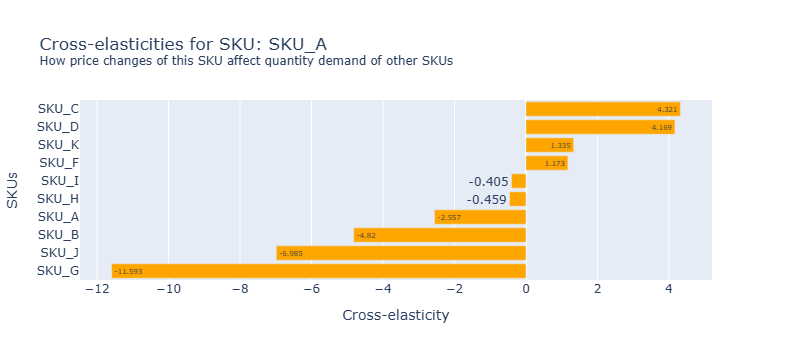

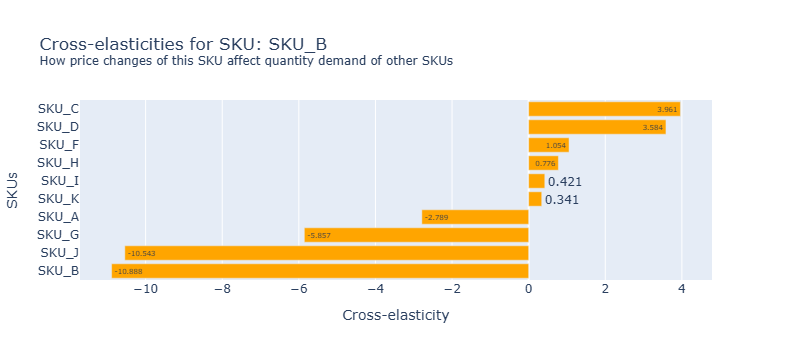

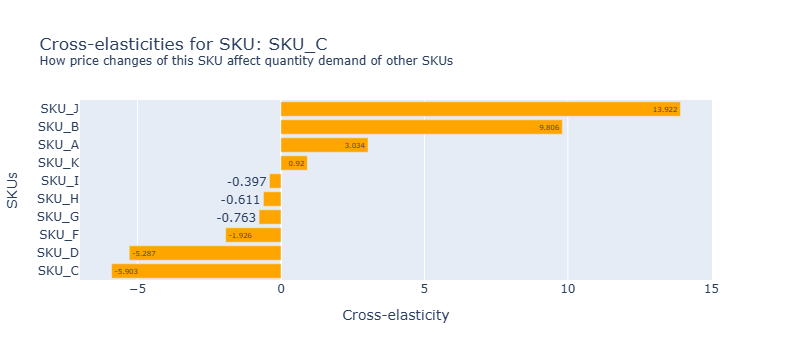

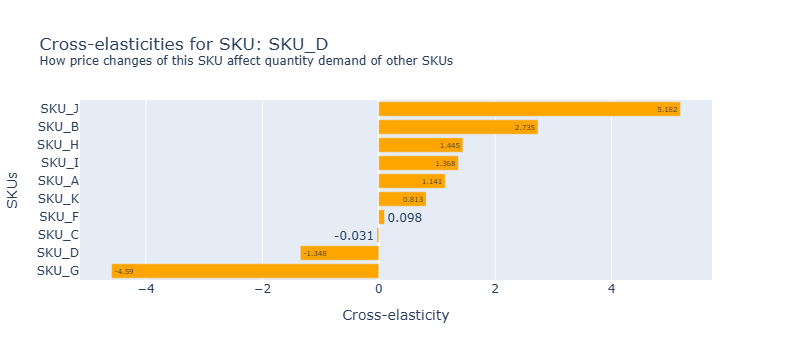

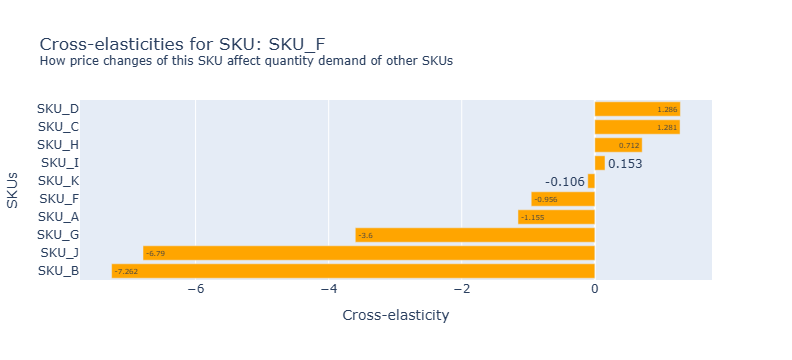

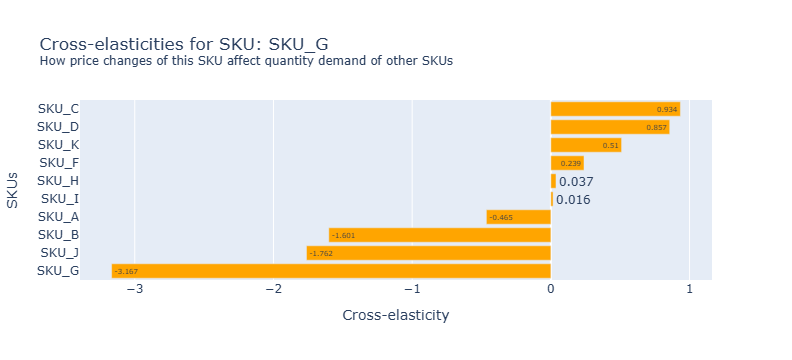

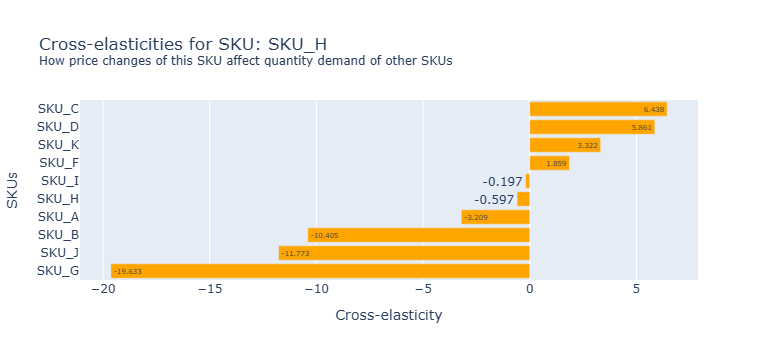

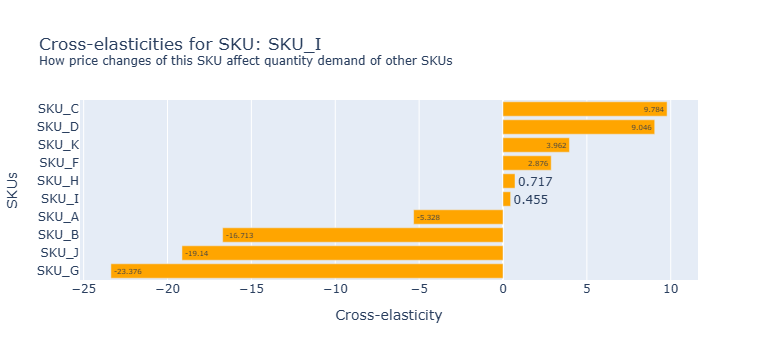

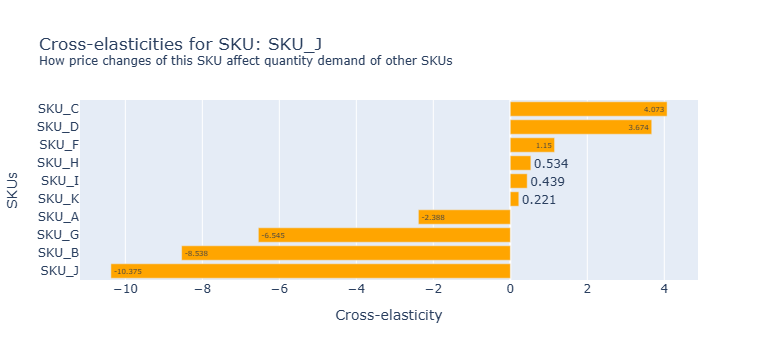

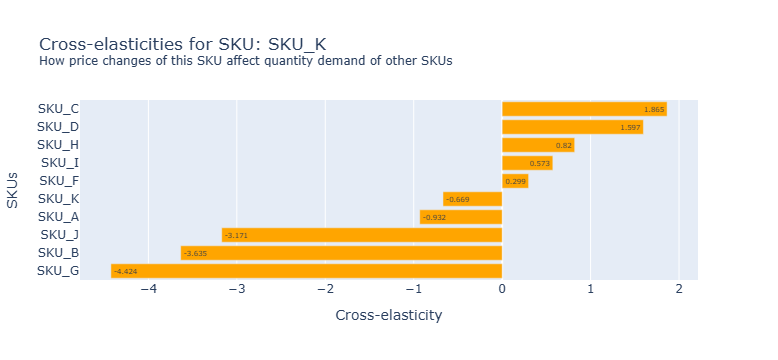

In [33]:
for unique_sku in sorted(df.sku.unique()):
    # Sort the DataFrame by cross-elasticity
    df_sorted = df_cross_elasticity_summary.loc[df_cross_elasticity_summary.SKU_p == unique_sku].sort_values(
            by='cross-elasticity', ascending=False)
    figplotly = px.bar(
        df_sorted,
        x='cross-elasticity',
        y='SKU_q',
        orientation='h',
        color_discrete_sequence=['orange'],
        text='cross-elasticity',  # Show values on bars, optional
        title=f'Cross-elasticities for SKU: {unique_sku}<br><sup>How price changes of this SKU affect quantity demand of other SKUs</sup>',
        labels={'cross-elasticity': 'Cross-elasticity', 'SKU_q': 'SKUs'}
        )

    # Reverse the y-axis to show highest elasticity at the top
    figplotly.update_layout(yaxis=dict(autorange='reversed'))

    # Show the plot
    figplotly.show()